In [2]:
%matplotlib notebook

import sys
import numpy as np
import cv2
import cvk2
from osgeo import gdal,ogr,osr
from pyproj import Proj
import georefUtils_py3
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pdb
import struct

In [ ]:
numPointCorrespondences = 50
#print("\nYou can find your UTM zone here: http://www.latlong.net/lat-long-utm.html")
utmZone = "2L"
print("Current UTM zone: ", utmZone)

# Read images
# googleEarthPath = "./images/Im_air_googleEarth2014_lowres.jpg"
# googleEarth = cv2.imread(googleEarthPath,0)
# UavPath = "./images/Im_air.tif"
# UAV = cv2.imread(UavPath,0)

largeAerialPath = "../Images/Aerial_RGB_2012.tif"
aerial_gtif = gdal.Open(largeAerialPath)
aerial_T = aerial_gtif.GetGeoTransform() # Transform to turn pixels to UTM
aerial_Tinv = gdal.InvGeoTransform(aerial_T) # Transform to turn UTM to pixels

# Transect1_HiResPath = "./images/Transect 1 Hi-Res.tiff"
# Transect1_HiRes = cv2.imread(Transect1_HiResPath)
# Transect1_HiRes = cv2.cvtColor(Transect1_HiRes[:,:,0:3], cv2.COLOR_BGR2RGB)

print("Size of Aerial {} x {} x {}".format(aerial_gtif.RasterXSize,
                                    aerial_gtif.RasterYSize,
                                    aerial_gtif.RasterCount))

Transect1Path = "../Images/July26_Priority1_flight_1_1_30frames_FL_2D.tif"
transect1_gtif = gdal.Open(Transect1Path)
print("Size of Transect1 {} x {} x {}".format(transect1_gtif.RasterXSize,
                                     transect1_gtif.RasterYSize,
                                     transect1_gtif.RasterCount))

try:
    srcband = aerial_gtif.GetRasterBand(1)
#     print("Band Type={}".format(gdal.GetDataTypeName(srcband.DataType)))
#     print(type(srcband))
except(RuntimeError, e):
    # for example, try GetRasterBand(10)
    print('Band ( %i ) not found', band_num)
    print(e)
    sys.exit(1)
    
aerial_corners = georefUtils_py3.getCorners(aerial_gtif,aerial_gtif.RasterYSize, aerial_gtif.RasterXSize)
#print("Corners of the image in UTM coordinates: ", aerial_corners)
aerial_corners_lonlat = georefUtils_py3.utmCoordinateToLatLong([aerial_corners[0][1], aerial_corners[0][0]],"2L")
transect_corners = georefUtils_py3.getCorners(transect1_gtif, transect1_gtif.RasterYSize, transect1_gtif.RasterXSize)
transect_corners_lonlat = georefUtils_py3.utmCoordinateToLatLong([transect_corners[0][1], transect_corners[0][0]], "2L")
print("Corners of Transect image in lon lat: ", transect_corners_lonlat)

Transect1_TL_latlon = [-14.181411, -169.658656]
Transect1_TR_latlon = [-14.181319, -169.658497]
Transect1_BL_latlon = [-14.182158, -169.657825]
Transect1_BR_latlon = [-14.181997, -169.657642]
Transect1_corners_latlon = [Transect1_TL_latlon,Transect1_TR_latlon,Transect1_BL_latlon,Transect1_BR_latlon]
Transect1_corners_UTM = georefUtils_py3.latlongCoordinateToUTM(Transect1_corners_latlon, "2L")
#print(Transect1_corners_UTM)

min_UTM_x = np.min(Transect1_corners_UTM[:,0])-10
max_UTM_x = np.max(Transect1_corners_UTM[:,0])+10
min_UTM_y = np.min(Transect1_corners_UTM[:,1])-10
max_UTM_y = np.max(Transect1_corners_UTM[:,1])+10
# print("Transect1_corners_UTM:",  Transect1_corners_UTM)
# Transect1_TL_UTM = georefUtils_py3.latlongCoordinateToUTM(Transect1_TL_latlon,"2S")
# Transect1_TR_UTM = georefUtils_py3.latlongCoordinateToUTM(Transect1_TR_latlon,"2S")
# Transect1_BL_UTM = georefUtils_py3.latlongCoordinateToUTM(Transect1_BL_latlon,"2S")
# Transect1_BR_UTM = georefUtils_py3.latlongCoordinateToUTM(Transect1_BR_latlon,"2S")
# min_UTM_x = np.min(Transect1_TL_UTM) 
# print("Transect1_UTM:", Transect1_UTM)

pixel_xy_TL = np.asarray(gdal.ApplyGeoTransform(aerial_Tinv, min_UTM_x, max_UTM_y)).astype(int)
pixel_xy_BR = np.asarray(gdal.ApplyGeoTransform(aerial_Tinv, max_UTM_x, min_UTM_y)).astype(int)
#print(pixel_xy_TL, pixel_xy_BR)
# print("XY coordinate:", pixel_xy)


<IPython.core.display.Javascript object>


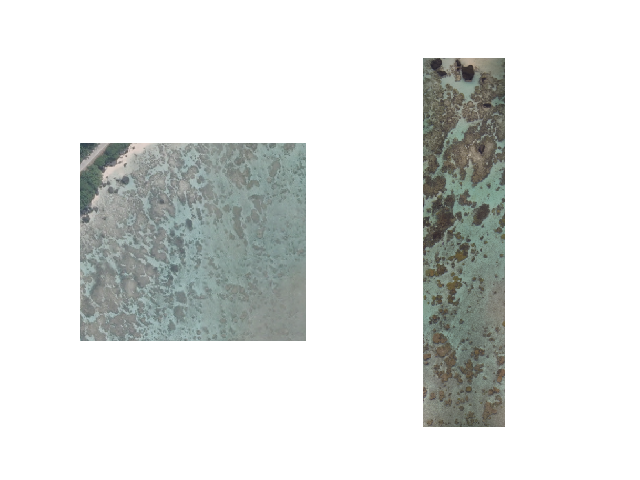

Size of localized Aerial:  (378, 430, 3)
Size of localized Hi-Res Transect:  (540, 119, 3)


In [3]:
width = int(pixel_xy_BR[0] - pixel_xy_TL[0])
height = int(pixel_xy_BR[1] - pixel_xy_TL[1])
fmt = "<" + ("h"*width)
air_capture = np.zeros((height,width,3))

for rastercount in range(1,4):
    srcband = aerial_gtif.GetRasterBand(rastercount)
    linecount = 0
    for y in range(pixel_xy_TL[1],pixel_xy_BR[1]):
        scanline = srcband.ReadRaster(xoff=int(pixel_xy_TL[0]), yoff=y, xsize=width, ysize=1, buf_xsize=width, buf_ysize=1, buf_type=gdal.GDT_Int16)
        values = struct.unpack(fmt, scanline)
        air_capture[linecount,:,rastercount-1] = np.asarray(values).astype(np.uint8)
        linecount = linecount+1
    
plt.figure(1)
plt.subplot(1,2,1)
plt.imshow(air_capture.astype(np.uint8))
plt.axis('off')

r = ((height*width)/(transect1_gtif.RasterXSize*transect1_gtif.RasterYSize))*10
dim = (int(Transect1_HiRes.shape[1]*r),int(Transect1_HiRes.shape[0]*r))
Transect1_resize = cv2.resize(Transect1_HiRes, dim, interpolation=cv2.INTER_AREA )
plt.subplot(1,2,2)
plt.imshow(Transect1_resize.astype(np.uint8))
plt.axis('off')

print("Size of localized Aerial: ", air_capture.shape)
print("Size of localized Hi-Res Transect: ", Transect1_resize.shape)


Finding image features...
Done.

Matching point correspondences...
Done.

Sorting matches
Done.



<IPython.core.display.Javascript object>


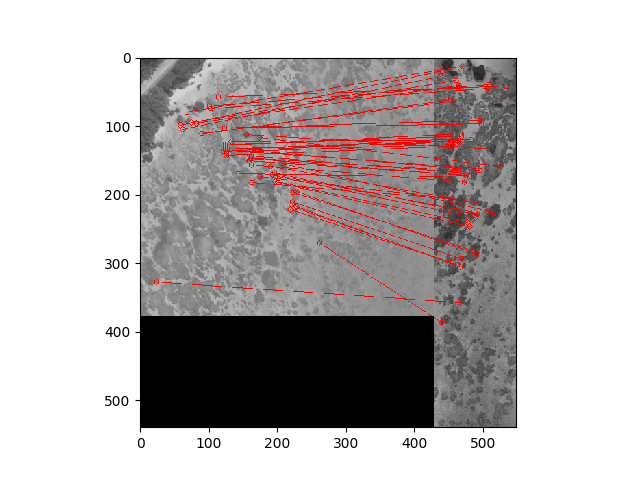

In [4]:
# Feature detector
sift = cv2.xfeatures2d.SIFT_create()

print("\nFinding image features...")
# Detect keypoints in both images
air_capture_gray = cv2.cvtColor(air_capture.astype(np.uint8), cv2.COLOR_RGB2GRAY)
Transect1_resize_gray = cv2.cvtColor(Transect1_resize, cv2.COLOR_RGB2GRAY)
(kp1,des1) = sift.detectAndCompute(air_capture_gray, None)
(kp2,des2) = sift.detectAndCompute(Transect1_resize_gray, None)
print("Done.\n")

# Match point correspondences
print("Matching point correspondences...")
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
# matches = bf.match(des1,des2)
matches = bf.match(des1, des2)
print("Done.\n")

print("Sorting matches")
matches = sorted(matches, key=lambda val: val.distance)
print("Done.\n")

# Keep only the best numPointCorrespondences point pairs. 
goodPointCorrespondences = matches[:numPointCorrespondences]

# Draw matches visualization
out = georefUtils_py3.drawMatches(air_capture_gray, kp1, Transect1_resize_gray, kp2, goodPointCorrespondences)

plt.figure(2)
plt.imshow(out)
plt.show()
#cv2.imwrite("matched_features_test.jpg", out)

In [5]:
points_lo = open("points_lo.txt", "w")
points_hi = open("points_hi.txt", "w")

points_lo_all = open("points_lo_all.txt", "w")
points_hi_all = open("points_hi_all.txt", "w")

_points_lo = []
_points_hi = []

print("Memorizing features")
i = 0
for pair in matches:
    # Get the matching keypoints for each of the images
    lo_idx = pair.queryIdx
    hi_idx = pair.trainIdx

    # x - columns
    # y - rows
    (x1,y1) = kp1[lo_idx].pt
    (x2,y2) = kp2[hi_idx].pt
    
    if i < len(goodPointCorrespondences):
        points_lo.write("{0} {1}\n".format(x1, y1))
        points_hi.write("{0} {1}\n".format(x2, y2))
        _points_lo.append((x1,y1))
        _points_hi.append((x2,y2))
    points_lo_all.write("{0} {1}\n".format(x1, y1))
    points_hi_all.write("{0} {1}\n".format(x2, y2))
    i += 1

points_lo.close()
points_hi.close()
print("Done.\n")

Memorizing features
Done.



In [7]:
print("Finding homography...")
_points_lo = np.asarray(_points_lo)
_points_hi = np.asarray(_points_hi)

# Calculate image sizes
image_lo = np.copy(air_capture.astype(np.uint8))
image_hi = np.copy(Transect1_resize.astype(np.uint8))
h_lo, w_lo, d_lo = image_lo.shape
size_lo = (w_lo, h_lo)

h_hi, w_hi, d_hi = image_hi.shape
size_hi = (w_hi, h_hi)

# Find a homography between the points
H, mask1= cv2.findHomography(_points_hi, _points_lo, method=cv2.RANSAC)
H_inv, mask2 = cv2.findHomography(_points_lo, _points_hi, method=cv2.RANSAC)

# Corner indices for each image
coords_lo = np.array( [ [[0, 0]],
                [[w_lo, 0]],
                [[w_lo, h_lo]],
                [[0, h_lo]] ], dtype='float32' )

coords_hi = np.array([ [[0, 0]],
                     [[w_hi, 0]],
                     [[w_hi, h_hi]],
                     [[0, h_hi]] ], dtype='float32')

# Find homography (Where the points from image_hi are on image_lo)
coords_transformed_hi2lo = cv2.perspectiveTransform(coords_hi, np.matrix(H))
coords_transformed_lo2hi = cv2.perspectiveTransform(coords_lo, np.matrix(H_inv)) # opposite

# Find a rectangle that bounds both images (size out output image where both images will be overlaid)
pointsToEncapsulate = np.append(np.array(coords_lo), np.array(coords_transformed_hi2lo), axis=0)
boundingRectangle = cv2.boundingRect(pointsToEncapsulate)

# T is the translation to get rid of negative coordinates
T = np.array([ [1, 0, -1*boundingRectangle[0]],
    [0, 1, -1*boundingRectangle[1]],
    [0, 0, 1] ], dtype='float32')

# homographyPrime is the homography with the translation factor
homographyPrime = np.dot(T, np.matrix(H))
destSizeWH = (boundingRectangle[2], boundingRectangle[3])

# Calculate the perspective transform
warped_lo = cv2.warpPerspective(image_lo, T, destSizeWH)
warped_hi = cv2.warpPerspective(image_hi, homographyPrime, destSizeWH)

pointsToEncapsulate2 = np.append(np.array(coords_hi), np.array(coords_transformed_lo2hi), axis=0)
boundingRectangle2 = cv2.boundingRect(pointsToEncapsulate2)
T2 = np.array([ [1, 0, -1*boundingRectangle2[0]],
    [0, 1, -1*boundingRectangle2[1]],
    [0, 0, 1] ], dtype='float32')
homographyPrime2 = np.dot(T2, np.matrix(H_inv))
destSizeWH2 = (boundingRectangle2[2], boundingRectangle2[3])
warped_lo2 = cv2.warpPerspective(image_lo, homographyPrime2, destSizeWH2)
# warped_hi2 = cv2.warpPerspective(image_hi, homographyPrime2, destSizeWH2)

Finding homography...


<IPython.core.display.Javascript object>


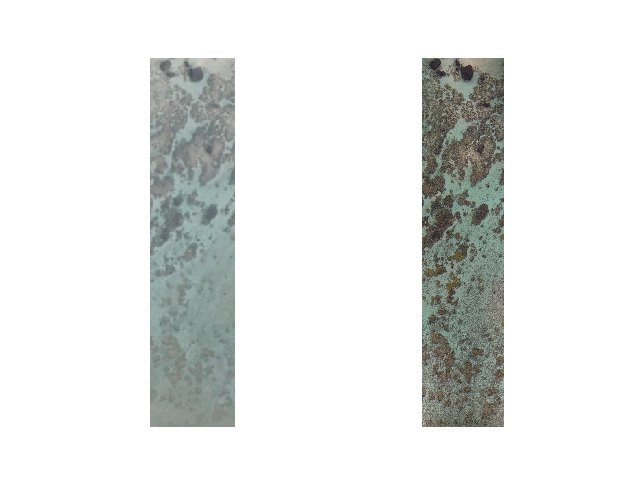

25.088560885608857
24.233870967741936


True

In [8]:
cornerpts = []
cornerpts.append(georefUtils_py3.mapPointThroughHomography(homographyPrime2*homographyPrime, (0, 0)))
cornerpts.append(georefUtils_py3.mapPointThroughHomography(homographyPrime2*homographyPrime, (0, h_hi)))
cornerpts.append(georefUtils_py3.mapPointThroughHomography(homographyPrime2*homographyPrime, (w_hi, h_hi)))
cornerpts.append(georefUtils_py3.mapPointThroughHomography(homographyPrime2*homographyPrime, (w_hi, 0)))
#temp2 = georefUtils_py3.mapPointThroughHomography(homographyPrime2, temp)

cornerpts = np.asarray(cornerpts)
finalimage = warped_lo2[min(cornerpts[:,1]):max(cornerpts[:,1]+1),min(cornerpts[:,0]):max(cornerpts[:,0])+1,:]
    
plt.figure(3)
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(finalimage.astype(np.uint8))

plt.subplot(1,2,2)
plt.imshow(Transect1_HiRes)
plt.axis('off')
plt.show()

print(Transect1_HiRes.shape[0]/finalimage.shape[0])
print(Transect1_HiRes.shape[1]/finalimage.shape[1])

cv2.imwrite("aerial_aligned_image.tif", cv2.cvtColor(finalimage, cv2.COLOR_RGB2BGR))

In [97]:
# This code places the high resolution image on top of the low resolution map 

# opencv window to preview tracked corners
uavCornersPreview = np.copy(warped_lo) # Note: this is a 3 channel RGB image. Only used for UI/preview. 
#uavCornersPreview = cv2.cvtColor(uavCornersPreview.astype(np.uint8), cv2.COLOR_GRAY2RGB) 
uavCornerIndices = []  # This is passed on to linearlyInterpolateUTM
uavCornerIndices.append(georefUtils_py3.mapPointThroughHomography(homographyPrime, (0, 0)))
uavCornerIndices.append(georefUtils_py3.mapPointThroughHomography(homographyPrime, (0, h_hi)))
uavCornerIndices.append(georefUtils_py3.mapPointThroughHomography(homographyPrime, (w_hi, h_hi)))
uavCornerIndices.append(georefUtils_py3.mapPointThroughHomography(homographyPrime, (w_hi, 0)))

pts = np.asarray(uavCornerIndices)
pts = pts.reshape((-1,1,2))
cv2.polylines(uavCornersPreview,[pts],True,(255,0,0))

# Show preview window
font = cv2.FONT_HERSHEY_SIMPLEX
for i, point in enumerate(uavCornerIndices):
    cv2.circle(uavCornersPreview, point, 3, 0)
    cv2.putText(uavCornersPreview, "corner"+str(i+1), point, font, 0.5, (0,0,0), 1)

cv2.imwrite("overlayP1.jpg", warped_lo)
cv2.imwrite("overlayP2.jpg", warped_hi)

# Overlay the images. We simply add the images (leads to dark areas, but that makes for better visualization anyways)
finalImage = np.zeros_like(warped_lo)
finalImage = np.add(0.5*warped_lo, 0.5*warped_hi)

print("Done.\n")

print("Writing output file \n")
cv2.imwrite("aligned_image.jpg", finalImage)
print("All done!\n")

Done.

Writing output file 

All done!



<IPython.core.display.Javascript object>


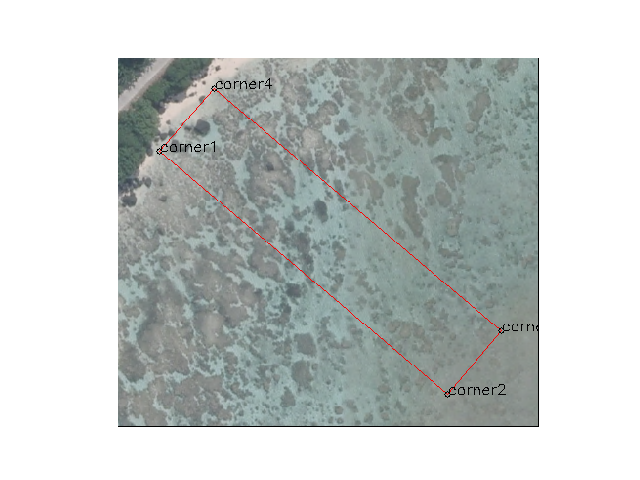

In [98]:
plt.figure(2)
plt.imshow(uavCornersPreview)
plt.axis('off')
plt.show()

In [3]:
# Test random patches across "aligned" images
AlignedUAVPath = "./aerial_aligned_image_test.tif"
AlignedUAV = cv2.cvtColor(cv2.imread(AlignedUAVPath), cv2.COLOR_BGR2RGB)

# Transect1_HiResPath = "../Images/July26_Priority1_flight_1_1_30frames_FL_2D.tif"
Transect1_HiResPath = "./uav_aligned_image_test.tif"
Transect1_HiRes = cv2.imread(Transect1_HiResPath)
Transect1_HiRes = cv2.cvtColor(Transect1_HiRes[:,:,0:3], cv2.COLOR_BGR2RGB)

xratio = (AlignedUAV.shape[1]/Transect1_HiRes.shape[1])
yratio = (AlignedUAV.shape[0]/Transect1_HiRes.shape[0])

<IPython.core.display.Javascript object>


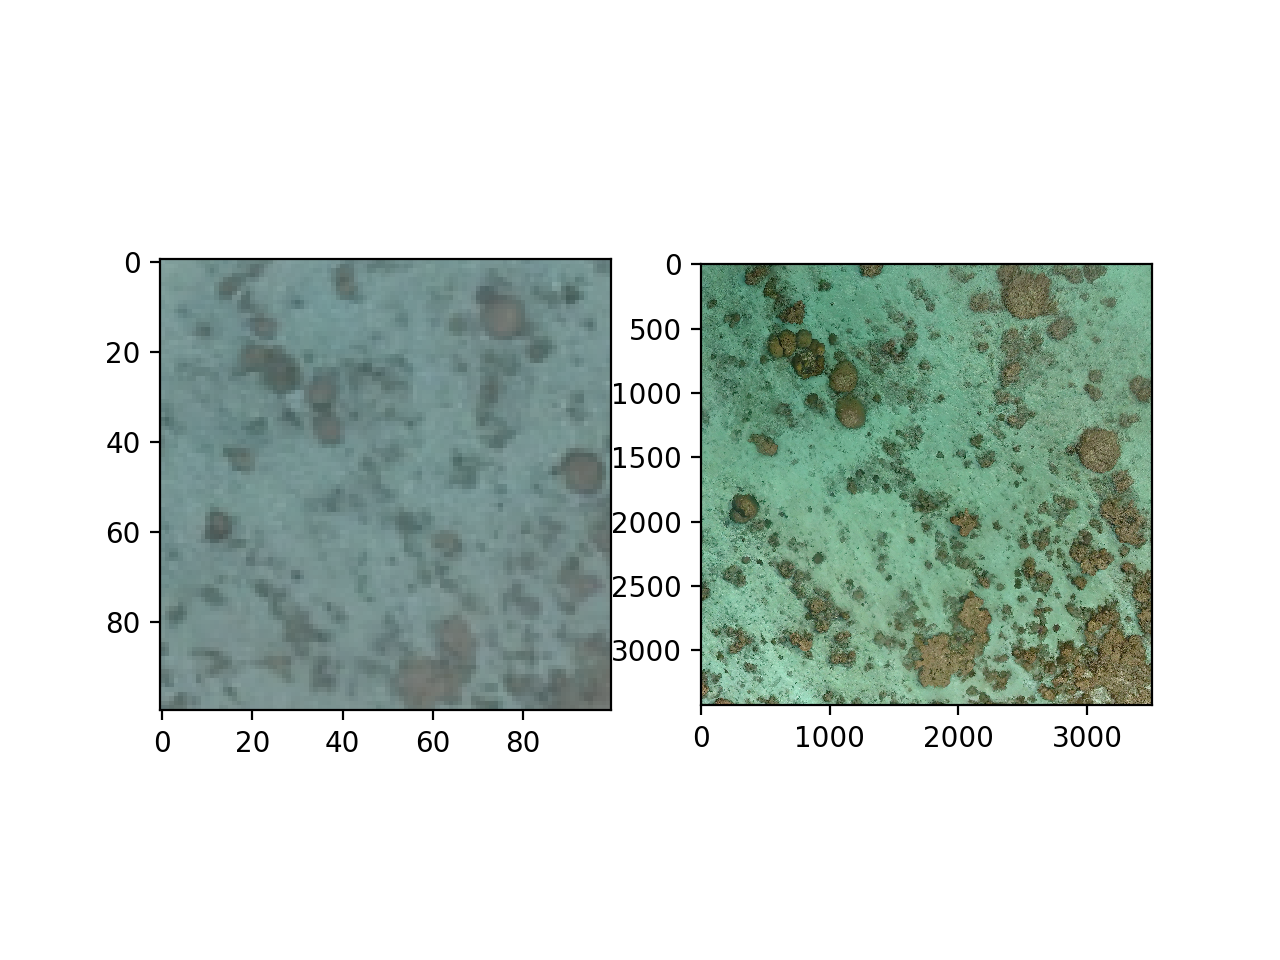

In [4]:
y = 160
x = 130
d = 100

plt.figure(5)
plt.subplot(1,2,1)
plt.imshow(AlignedUAV[y:y+d,x:x+d,:])
plt.subplot(1,2,2)
plt.imshow(Transect1_HiRes[int(y/yratio):int((y+d)/yratio), int(x/xratio):int((x+d)/xratio), :])
plt.show()